In [ ]:
# Nama : JIRYAN FAROKHI
# Email : jiryanfarokhi@gmail.com
# Domisili : Surabaya

In [ ]:
!pip install kaggle

In [ ]:
!chmod 600 /content/kaggle.json

In [ ]:
!KAGGLE_CONFIG_DIR=/content/ kaggle datasets download -d parulpandey/emotion-dataset

emotion-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import zipfile
zip_file = zipfile.ZipFile('/content/emotion-dataset.zip', 'r')
zip_file.extractall('/tmp/')

In [ ]:
import pandas as pd
validation = pd.read_csv('/tmp/test.csv')
train = pd.read_csv('/tmp/training.csv')
test = pd.read_csv('/tmp/test.csv')

In [ ]:
frames = [validation, train, test]
result = pd.concat(frames).drop_duplicates().reset_index(drop=True)

In [ ]:
result.to_csv(r'datasets.csv', index=False)

In [ ]:
df = pd.read_csv('datasets.csv')

In [ ]:
df.tail()

,text,label
17994,i just had a very brief time in the beanbag an...,0
17995,i am now turning and i feel pathetic that i am...,0
17996,i feel strong and good overall,1
17997,i feel like this was such a rude comment and i...,3
17998,i know a lot but i feel so stupid because i ca...,0


In [ ]:
from datasets import Dataset,DatasetDict,Features,Value,ClassLabel

class_names = ['sedih', 'senang', 'cinta', 'marah', 'takut', 'terkejut']
ft = Features({'text': Value('string'), 'label': ClassLabel(names=class_names)})


emotions = DatasetDict({
    "df": Dataset.from_pandas(df,features=ft),
})


In [ ]:
emotions.set_format(type="pandas")
emotions

DatasetDict({
    df: Dataset({
        features: ['text', 'label'],
        num_rows: 17999
    })
})

In [ ]:
def label_int2str(row):
    return emotions["df"].features["label"].int2str(row)

df["emotions"] = df["label"].apply(label_int2str)
df

,text,label,emotions
0,im feeling rather rotten so im not very ambiti...,0,sedih
1,im updating my blog because i feel shitty,0,sedih
2,i never make her separate from me because i do...,0,sedih
3,i left with my bouquet of red and yellow tulip...,1,senang
4,i was feeling a little vain when i did this one,0,sedih
...,...,...,...
17994,i just had a very brief time in the beanbag an...,0,sedih
17995,i am now turning and i feel pathetic that i am...,0,sedih
17996,i feel strong and good overall,1,senang
17997,i feel like this was such a rude comment and i...,3,marah


In [ ]:
import plotly.express as px

px.bar(df['emotions'].value_counts(ascending=True),template='plotly_white')

In [ ]:
df["Words Per Tweet"] = df["text"].str.split().apply(len)

px.box(df,y='Words Per Tweet',
       color='emotions',
       template='plotly_white')

In [ ]:
category = pd.get_dummies(df.emotions)
df_baru = pd.concat([df, category], axis=1)
df_baru = df_baru.drop(columns='emotions')
df_baru

,text,label,Words Per Tweet,cinta,marah,sedih,senang,takut,terkejut
0,im feeling rather rotten so im not very ambiti...,0,11,0,0,1,0,0,0
1,im updating my blog because i feel shitty,0,8,0,0,1,0,0,0
2,i never make her separate from me because i do...,0,22,0,0,1,0,0,0
3,i left with my bouquet of red and yellow tulip...,1,21,0,0,0,1,0,0
4,i was feeling a little vain when i did this one,0,11,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...
17994,i just had a very brief time in the beanbag an...,0,24,0,0,1,0,0,0
17995,i am now turning and i feel pathetic that i am...,0,20,0,0,1,0,0,0
17996,i feel strong and good overall,1,6,0,0,0,1,0,0
17997,i feel like this was such a rude comment and i...,3,14,0,1,0,0,0,0


In [ ]:
text = df_baru['text'].values
label = df_baru[['sedih', 'senang', 'cinta', 'marah', 'takut', 'terkejut']].values

In [ ]:
from sklearn.model_selection import train_test_split
text_latih, text_test, label_latih, label_test = train_test_split(text, label, test_size=0.2)

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=5000, oov_token='x')
tokenizer.fit_on_texts(text_latih)
tokenizer.fit_on_texts(text_test)

sekuens_latih = tokenizer.texts_to_sequences(text_latih)
sekuens_test = tokenizer.texts_to_sequences(text_test)

padded_latih = pad_sequences(sekuens_latih)
padded_test = pad_sequences(sekuens_test)

In [ ]:
import tensorflow as tf
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=5000, output_dim=16),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
label_latih.shape

(14399, 6)

In [ ]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(patience=5)
num_epochs = 30
history = model.fit(padded_latih, label_latih, epochs=num_epochs,
                    validation_data=(padded_test, label_test), verbose=2, callbacks=[early_stopping])

Epoch 1/30
450/450 - 17s - loss: 0.0391 - accuracy: 0.9860 - val_loss: 0.4506 - val_accuracy: 0.9019 - 17s/epoch - 38ms/step
Epoch 2/30
450/450 - 14s - loss: 0.0437 - accuracy: 0.9846 - val_loss: 0.4985 - val_accuracy: 0.9053 - 14s/epoch - 31ms/step
Epoch 3/30
450/450 - 14s - loss: 0.0337 - accuracy: 0.9886 - val_loss: 0.5142 - val_accuracy: 0.9033 - 14s/epoch - 30ms/step
Epoch 4/30
450/450 - 14s - loss: 0.0333 - accuracy: 0.9893 - val_loss: 0.5291 - val_accuracy: 0.8989 - 14s/epoch - 31ms/step
Epoch 5/30
450/450 - 14s - loss: 0.0311 - accuracy: 0.9893 - val_loss: 0.5234 - val_accuracy: 0.9011 - 14s/epoch - 31ms/step
Epoch 6/30
450/450 - 16s - loss: 0.0284 - accuracy: 0.9906 - val_loss: 0.5170 - val_accuracy: 0.9031 - 16s/epoch - 37ms/step


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

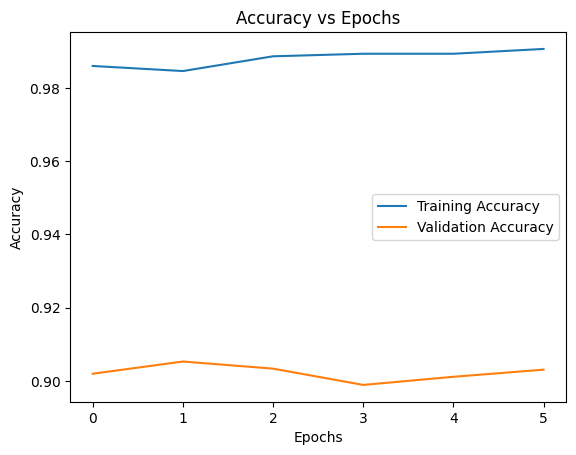

In [ ]:
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

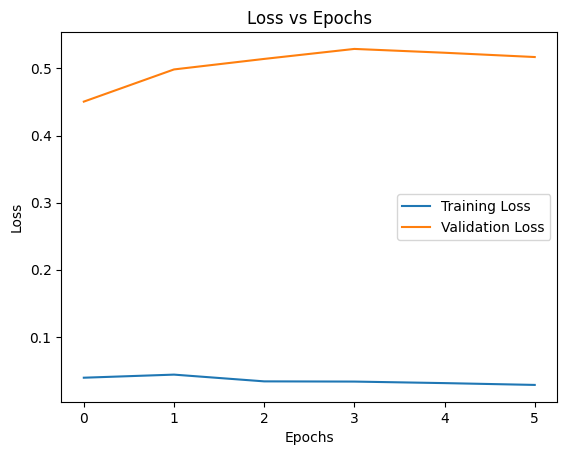

In [ ]:
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()